#### dependencies

In [ ]:
!pip install EMD-signal
!pip install prophet
!pip install xlrd ==2.0.1
!pip install pmdarima

In [ ]:
# !pip freeze > requirements.txt
# !pip uninstall -r requirements.txt -y

#### imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error , mean_squared_error, mean_absolute_error

In [ ]:
from PyEMD import EMD
from PyEMD import CEEMDAN
from prophet import Prophet
from pmdarima import auto_arima

# **7.Accidents**

## 7.0 Data

In [ ]:
acc_test_size = 15

In [ ]:
acc_df =pd.read_excel("/Datasets/Accident.xlsx")
acc_ds = pd.date_range(start = "1973-01-01",periods= len(acc_df), freq="MS" )
acc_df['ds'] =  acc_ds
acc_df

In [ ]:
acc_df.info()

In [ ]:
acc_df.describe()

In [ ]:
acc_train_set = acc_df[:-(acc_test_size)]
acc_test_set = acc_df[-(acc_test_size):]

##7.1 Prophet

In [ ]:
acc_prophet = Prophet(seasonality_mode="multiplicative")
acc_prophet.fit(acc_train_set)
acc_future = acc_prophet.make_future_dataframe(len(acc_test_set), freq="MS")
acc_forecast = acc_prophet.predict(acc_future)

##7.2 Prophet-EMD

### decomposition

In [ ]:
emd = EMD()
acc_imfs = emd.emd(acc_train_set.y.values)

In [ ]:
acc_imfs.shape

(5, 57)

### +Prophet

In [ ]:
acc_forecast_temp=pd.DataFrame()
acc_forecast_temp["ds"] = acc_ds
acc_forecast_temp["yhat"] = 0

for imf in acc_imfs:
  temp = pd.DataFrame(imf)
  temp['ds'] = acc_ds[:len(acc_train_set)]
  temp.columns = [ 'y', 'ds']
  model = Prophet(seasonality_mode="multiplicative")
  model.fit(temp)
  future = model.make_future_dataframe(acc_test_size, freq="MS")
  acc_emd_forecast = model.predict(future)
  acc_forecast_temp["yhat"] += acc_emd_forecast['yhat']

## 7.3 Prophet-CEEMDAN

### decomposition

In [ ]:
cemd = CEEMDAN()
acc_c_imfs = cemd.ceemdan(acc_train_set.y.values)

In [ ]:
acc_c_imfs.shape

(5, 57)

### +Prophet

In [ ]:
acc_c_forecast_temp=pd.DataFrame()
acc_c_forecast_temp["ds"] = acc_ds
acc_c_forecast_temp["yhat"] = 0

for imf in acc_c_imfs:
  temp = pd.DataFrame(imf)
  temp['ds'] = acc_ds[:len(acc_train_set)]
  temp.columns = [ 'y', 'ds']
  c_model = Prophet(seasonality_mode="multiplicative")
  c_model.fit(temp)
  future = c_model.make_future_dataframe(acc_test_size, freq="MS")
  acc_cemd_forecast = c_model.predict(future)
  acc_c_forecast_temp["yhat"] += acc_cemd_forecast['yhat']

## 7.4 Prophet-ICEEMDAN

### import

In [ ]:
acc_ic_imfs = pd.read_csv("/ICEEMDAN-IMFS/IMF_acc.csv", header = None)
acc_ic_imfs = acc_ic_imfs.to_numpy()
acc_ic_imfs.shape

(5, 57)

### +Prophet

In [ ]:
acc_ic_forecast_temp=pd.DataFrame()
acc_ic_forecast_temp["ds"] = acc_ds
acc_ic_forecast_temp["yhat"] = 0

for imf in acc_ic_imfs:
  temp = pd.DataFrame(imf)
  temp['ds'] = acc_ds[:len(acc_train_set)]
  temp.columns = [ 'y', 'ds']
  ic_model = Prophet(seasonality_mode= "additive")
  ic_model.fit(temp)
  future = ic_model.make_future_dataframe(acc_test_size, freq="MS")
  acc_icemd_forecast = ic_model.predict(future)
  acc_ic_forecast_temp["yhat"] += acc_icemd_forecast['yhat']

## 7.5 SARIMAX

In [ ]:
acc_temp = acc_train_set.copy()
acc_temp.index = acc_train_set.ds
acc_temp.drop("ds", axis=1,inplace=True)
acc_temp

In [ ]:
acc_model_arima = auto_arima(acc_temp,seasonal=True, stationary=True, m=6)
acc_forecast_arima = acc_model_arima.predict(len(acc_test_set))

In [ ]:
acc_model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   57
Model:               SARIMAX(0, 0, 4)   Log Likelihood                -448.728
Date:                Thu, 10 Aug 2023   AIC                            909.456
Time:                        13:54:14   BIC                            921.715
Sample:                    01-01-1973   HQIC                           914.220
                         - 09-01-1977                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8549.8066    338.734     25.240      0.000    7885.901    9213.713
ma.L1          0.9921      0.136      7.319      0.000       0.726       1.258
ma.L2          0.7857      0.167      4.714      0.000       0.459       1.112
ma.L3          0.3008      0.182      1.651      0.099      -0.056       0.658
ma.L4         -0.3197      0.176     -1.816      0.069      -0.665       0.025
sigma2       3.69e+05   9.42e+04      3.916      0.000    1.84e+05    5.54e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 4.98
Prob(Q):                              0.81   Prob(JB):                         0.08
Heteroskedasticity (H):               1.02   Skew:                             0.72
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# plots

### test set chart

In [ ]:
def plotting_test(df, df_p, df_ep, df_cp, df_icp, df_s, ylabel, xlabel, name, test_size):
  fig, ax = plt.subplots(layout="constrained", figsize=(12,7))
  plt.rcParams['font.family'] = 'serif'
  plt.rcParams['font.serif'] += ['Times New Roman']

  width = 3
  msize = 9

  ax.plot(df.ds[-test_size:], df.y[-test_size:], label = "Original",color ='black', marker = 'o', ms= msize-2, lw=width, mfc = 'white', zorder=10, alpha=0.9)
  ax.plot(df_p.ds[-test_size:], df_p.yhat[-test_size:], label = "Prophet", marker = 'X', ms = msize+1, lw=width, mfc='white')
  ax.plot(df_ep.ds[-test_size:], df_ep.yhat[-test_size:], label = "Prophet-EMD", marker = '^', markersize = msize, lw=width,  mfc = 'white')
  ax.plot(df_cp.ds[-test_size:], df_cp.yhat[-test_size:], label = "Prophet-CEEMDAN", marker = 'h', ms = msize+1, lw=width, mfc='white')
  ax.plot(df_icp.ds[-test_size:], df_icp.yhat[-test_size:], label = "Prophet-ICEEMDAN", marker = 'P', ms = msize, lw=width, mfc='white' , alpha=1)
  ax.plot(df_cp.ds[-test_size:], df_s,  label = "SARIMAX", marker='v', ms=msize+1, lw=width, mfc='white')

  plt.margins(0.05,0.5)
  ax.legend(fontsize = 15, loc='upper left')
  plt.grid(axis='y')
  plt.ylabel(ylabel, fontsize=17, labelpad=15, fontfamily= "serif", fontweight="bold")
  plt.xlabel(xlabel, fontsize=17, labelpad=10, fontfamily= "serif", fontweight="bold")
  ceil = ax.get_ylim()
  plt.ylim(ceil[0], ceil[1]+(0.05*ceil[1]))

  plt.xticks(df.ds[-test_size:], rotation = 30, fontweight="bold", fontsize = 13)
  plt.yticks(fontweight='bold', fontsize = 13)

  plt.savefig(name, dpi=1200)


#### reading data

In [ ]:
acc_df =pd.read_excel("/Datasets/Accident.xlsx")
acc_ds = pd.date_range(start = "1973-01-01",periods= len(acc_df), freq="MS" )
acc_df['ds'] =  acc_ds

In [ ]:
acc_df_p = pd.read_excel("/Forecasts/accident/acc_prophet.xlsx")
acc_df_p = acc_df_p[['ds', 'yhat']]

In [ ]:
acc_df_ep = pd.read_excel("/forecasts/accident/acc_EMD_Prophet.xlsx")
acc_df_ep = acc_df_ep[['ds', 'yhat']]

In [ ]:
acc_df_cp = pd.read_excel("/forecasts/accident/acc_CEEMDAN_Prophet.xlsx")
acc_df_cp = acc_df_cp[['ds', 'yhat']]

In [ ]:
acc_df_icp = pd.read_excel("/forecasts/accident/acc_iCEEMDAN_Prophet.xlsx")
acc_df_icp = acc_df_icp[['ds', 'yhat']]

In [ ]:
acc_df_s = pd.read_excel("/forecasts/accident/acc_SARIMAX.xlsx")
acc_df_s = acc_df_s[0]
acc_df_s.columns=['yhat']

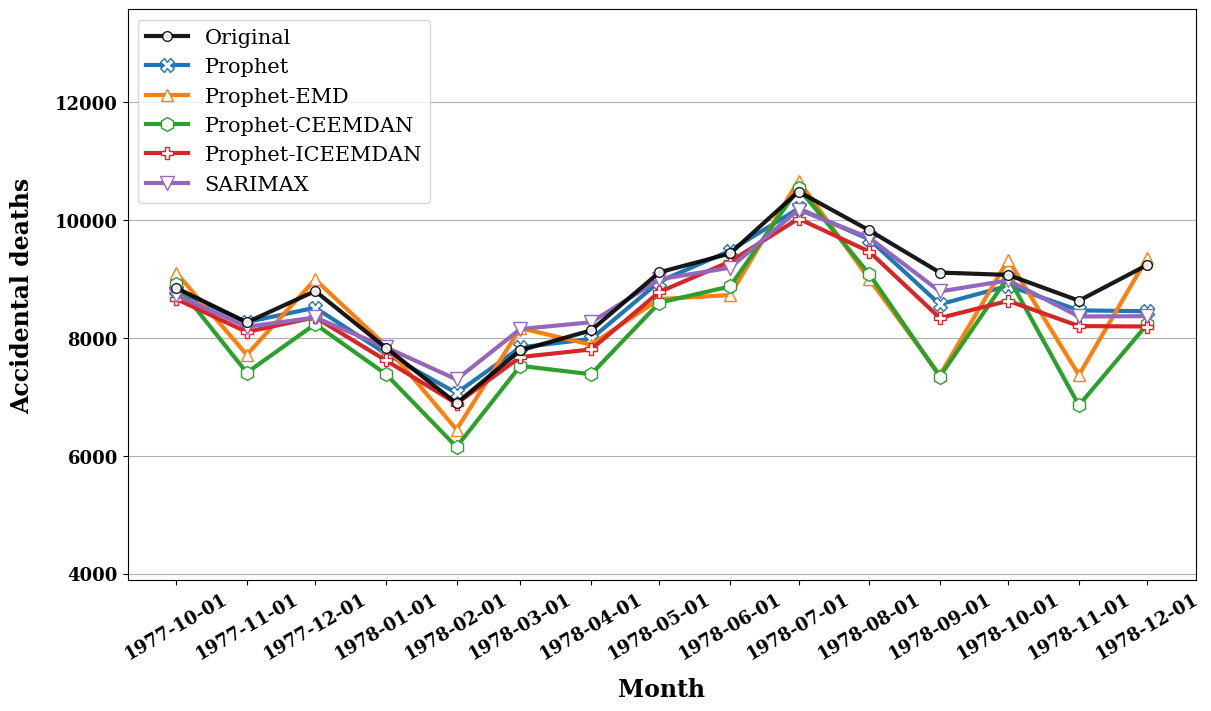

In [ ]:
plotting_test(acc_df, acc_df_p, acc_df_ep, acc_df_cp,acc_df_icp, acc_df_s, "Accidental deaths", "Month", "accident_test_func.jpg", test_size = 15)

### bar plot

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] += ['Times Roman']
width = 0.1

def bar_plotter(values, title, name, tick):
  xticks = ['MAPE']
  multiplier = 0
  x = np.arange(len(xticks))

  fig, ax = plt.subplots(layout="constrained", figsize=(10,6))

  for i,j in values.items():
    offset = width * multiplier
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] += ['Times Roman']
    rects = ax.bar(x + offset, j, width, label = i)
    ax.bar_label(rects, padding=4, fontweight="bold", fontsize=13)
    multiplier+=1

  plt.legend(fontsize=13, loc="upper left")

  ax.set_xticks(x+tick, xticks, fontsize=14, fontweight="bold")
  plt.yticks(fontweight='bold', fontsize=14)

  ceil = round(max(list(values.values())) + 0.2*(max(list(values.values()))))

  plt.ylim(0, ceil)

  plt.grid(axis='y')
  ax.set_axisbelow(True)
  plt.margins(2*(1-len(values)/10), 0)
  plt.savefig(f"{name}.jpg", dpi=1200)

round


In [ ]:
def rounder(dictionary):
  for i,j in dictionary.items():
    dictionary[i] = round(j, 2)
  return(dictionary)

In [ ]:
acc_values = {
    # model : (MAPE)
    "Prophet":(2.32),
    "Prophet-EMD": (5.804),
    "Prophet-CEEMDAN":(5.53),
    "Prophet-ICEEMDAN":(4.012),
    "SARIMA":(2.98),
}

bar_plotter(rounder(acc_values), "Accident", "Accident_comparison_bar",0.2)